# $\text{Variational Monte Carlo for Helium Atom}$
- Name: Utkarsh Maurya
- Roll No.: PH21B012

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from tqdm import tqdm
import math
import pandas as pd

$\text{Wavefunctions:}$  
$$\psi_{T1}(\mathbf{r_1},\mathbf{r_2},\mathbf{r_{12}}) = exp(-\alpha(r_1 + r_2))$$  
$$\psi_{T2}(\mathbf{r_1},\mathbf{r_2},\mathbf{r_{12}}) = exp(-\alpha(r_1 + r_2))(1 + \beta r_{12})$$
$$\psi_{T3}(\mathbf{r_1},\mathbf{r_2},\mathbf{r_{12}}) = exp(-\alpha(r_1 + r_2))exp(\frac{r_{12}}{2(1 + \beta r_{12})})$$

## $\text{Ansatz 1}$

### $\text{Defining Functions}$

In [28]:
# Wavefunction 1

@njit(cache=True)
def psi_1(r, a):
    m,n = r.shape
    arg = 0.0
    for i in range(m): 
        r_particle = 0.0
        for j in range(n):
            r_particle += r[i,j]**2
        arg += math.sqrt(r_particle)
    return math.exp(-a*arg)

In [29]:
# Local energy for Wavefunction 1

@njit(cache=True)
def local_energy_1(r, a, Z):
    eps = 1e-9
    r1_sq = 0.0
    for i in range(3):
        r1_sq += r[0,i]**2
    r1 = math.sqrt(r1_sq) + eps
       
    r2_sq = 0.0
    for i in range(3):
        r2_sq += r[1,i]**2
    r2 = math.sqrt(r2_sq) + eps
       
    r12_sq = 0.0
    for k in range(3):
        r12_sq += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12_sq) + eps
            
    E = (a - Z)*(1/r1 + 1/r2) + 1/r12 - a**2
    return E

In [30]:
# Monte Carlo
@njit(cache=True)
def monte_carlo_1(r, a, Z, N_thermal, N, step):
    energy = 0.0
    energy2 = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_1(r, a)
        wave_new = psi_1(r_new, a)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_1(r, a)
        wave_new = psi_1(r_new, a)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        dE = local_energy_1(r, a, Z)
        energy += dE
        energy2 += dE**2
        
    return energy, energy2

@njit(cache=True)
def VMC_1(r, a, Z, N_thermal, N, step):
    energy, energy2 = monte_carlo_1(r.copy(), a, Z, N_thermal, N, step)
    
    energy_mean = energy / N
    energy_var = energy2 / N - energy_mean**2
    

    return energy_mean, energy_var

### $\text{Data for Ansatz 1}$

In [ ]:
def ansatz1():
    N_thermal = 10**3
    step = 1.0

    Z = 2

    r = step * (np.random.random((2,3)) - 0.5)

    alpha_list = np.linspace(1, 2, 21)

    N = 10**7
    results_coarse = []
    for i in tqdm(range(len(alpha_list))):
        res = VMC_1(r.copy(), alpha_list[i], Z, N_thermal, N, step)
        results_coarse.append((alpha_list[i], res[0], res[1]))
    combined_df = pd.DataFrame(results_coarse, columns=['alpha', 'energy', 'variance'])

    return combined_df

combined_df_1 = ansatz1()

100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


In [32]:
E_list_1 = combined_df_1['energy']
alpha_list_1 = combined_df_1['alpha']
opt_alpha_1 = alpha_list_1[np.argmin(E_list_1)]
combined_df_1

,alpha,energy,variance
0,1.00,-2.375933,1.886159
1,1.05,-2.442686,1.833708
2,1.10,-2.500976,1.771708
3,1.15,-2.559665,2.195652
4,1.20,-2.609519,1.619018
5,1.25,-2.654875,1.557787
6,1.30,-2.697265,1.484547
7,1.35,-2.733207,1.425528
8,1.40,-2.766759,1.370872
9,1.45,-2.792268,1.222264


### $\text{Plot for Ansatz 1}$

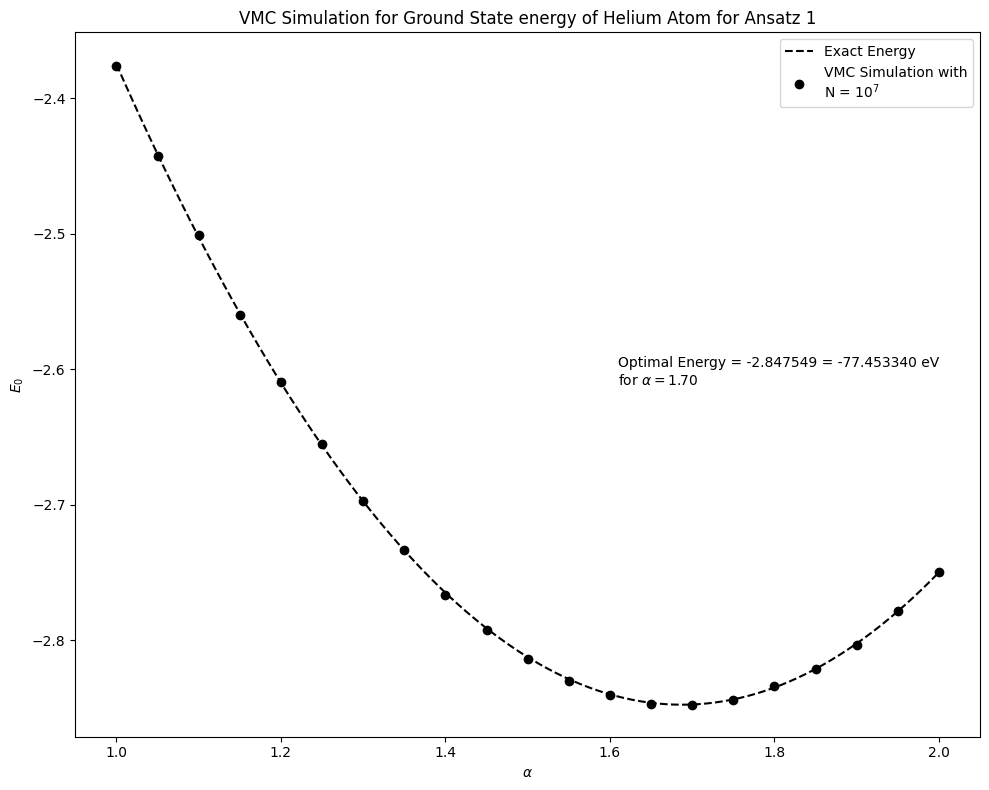

In [34]:
def exact_energy_He(z):
    return z**2 - 4*z + 5/8*z
a1 = np.linspace(1,2,100)
plt.figure(figsize=(10,8))
plt.plot(a1, exact_energy_He(a1),'k--',label='Exact Energy')
plt.plot(alpha_list_1, E_list_1,'ko', label='VMC Simulation with\nN = $10^7$')
plt.title('VMC Simulation for Ground State energy of Helium Atom for Ansatz 1')
plt.xlabel('$\\alpha$')
plt.ylabel('$E_0$')
plt.legend()
plt.tight_layout()
plt.text(0.6,0.5,
         "Optimal Energy = %f = %f eV \nfor $\\alpha = %0.2f$"%(min(E_list_1),min(E_list_1)*2*13.6, opt_alpha_1),
         transform=plt.gca().transAxes)
plt.show()

### $\text{Mean } r_{12} \text{ for Ansatz 1}$

In [35]:
@njit(cache = True)
def r12_monte_carlo_1(r, a, Z, N_thermal, N, step):
    r12_sum = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_1(r, a)
        wave_new = psi_1(r_new, a)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_1(r, a)
        wave_new = psi_1(r_new, a)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        r_12 = 0.0
        for k in range(3):
            r_12 += (r[0,k]-r[1,k])**2
        r12 = math.sqrt(r_12)
        
        r12_sum += r12
        
    return r12_sum / N

In [36]:
N_thermal = 10**3
N = 10**7
a = opt_alpha_1
step = 1.0
Z = 2

r = step * (np.random.random((2,3)) - 0.5)

r12opt_1 = r12_monte_carlo_1(r, a, Z, N_thermal, N, step)
print(r12opt_1)

1.2877844554943152


In [37]:
print("Comments:")
print(f"- Optimal value of alpha for Ansatz 1 = {opt_alpha_1: 0.3f}")
print(f"- Mean r_12 for Ansatz 1 = {r12opt_1: 0.3f}")

Comments:
- Optimal value of alpha for Ansatz 1 =  1.700
- Mean r_12 for Ansatz 1 =  1.288


## $\text{Ansatz 2}$

### $\text{Defining Functions}$

In [38]:
# Wavefunction 2

@njit(cache=True)
def psi_2(r, a, b):
    m,n = r.shape
    arg = 0.0
    for i in range(m):
        r_particle = 0.0
        for j in range(n):
            r_particle += r[i,j]**2
        arg += math.sqrt(r_particle)

    r_12 = 0.0
    for k in range(n):
        r_12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r_12)
    return math.exp(-a*arg) * (1 + b*r12)


In [39]:
# Local energy for Wavefunction 2

@njit(cache=True)
def local_energy_2(r, a, b, Z):
    eps = 1e-9
    r1_sq = 0.0
    for i in range(3):
        r1_sq += r[0,i]**2
    r1 = math.sqrt(r1_sq) + eps
       
    r2_sq = 0.0
    for i in range(3):
        r2_sq += r[1,i]**2
    r2 = math.sqrt(r2_sq) + eps
       
    r12_sq = 0.0
    for k in range(3):
        r12_sq += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12_sq) + eps
        
    T_dot = (r1_sq - r2_sq + r12_sq)/(2 * r1 * r12) + (r2_sq - r1_sq + r12_sq)/(2 * r2 * r12)
    
    E = (a - Z)*(1/r1 + 1/r2) + 1/r12 - a**2 + b/(1 + b*r12) * (-2/r12 + a * T_dot) 
    return E


In [40]:
# Monte Carlo for Wavefunction 2

@njit(cache=True)
def monte_carlo_2(r, a, b, Z, N_thermal, N, step):
    energy = 0.0
    energy2 = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_2(r, a, b)
        wave_new = psi_2(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_2(r, a, b)
        wave_new = psi_2(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        dE = local_energy_2(r, a, b, Z)
        energy += dE
        energy2 += dE**2
        
    return energy, energy2

@njit(cache=True)
def VMC_2(r, a, b, Z, N_thermal, N, step):
    energy, energy2 = monte_carlo_2(r.copy(), a, b, Z, N_thermal, N, step)
    
    energy_mean = energy / N
    energy_var = energy2 / N - energy_mean**2
    
    return energy_mean, energy_var


### $\text{Data for Ansatz 2}$

In [41]:

def ansatz2():
    N_thermal = 10**3
    step = 1.0

    Z = 2

    r = step * (np.random.random((2,3)) - 0.5)

    beta_list = np.linspace(0, 1, 21)
    a = opt_alpha_1
    N = 10**7
    results_coarse = []
    for i in tqdm(range(len(beta_list))):
        res = VMC_2(r.copy(), a, beta_list[i], Z, N_thermal, N, step)
        results_coarse.append((beta_list[i], res[0], res[1]))
    combined_df = pd.DataFrame(results_coarse, columns=['beta', 'energy', 'variance'])

    return combined_df

combined_df_2 = ansatz2()

100%|██████████| 21/21 [00:45<00:00,  2.17s/it]


In [42]:
E_list_2 = combined_df_2['energy']
beta_list_2 = combined_df_2['beta']
opt_beta_2 = beta_list_2[np.argmin(E_list_2)]
combined_df_2

,beta,energy,variance
0,0.00,-2.847812,0.887386
1,0.05,-2.861041,0.700420
2,0.10,-2.871066,0.544657
3,0.15,-2.874853,0.484974
4,0.20,-2.876366,0.424106
5,0.25,-2.875723,0.419448
6,0.30,-2.874759,0.365516
7,0.35,-2.871040,0.379913
8,0.40,-2.867615,0.360474
9,0.45,-2.863143,0.391830


### $\text{Plot for Ansatz 2}$

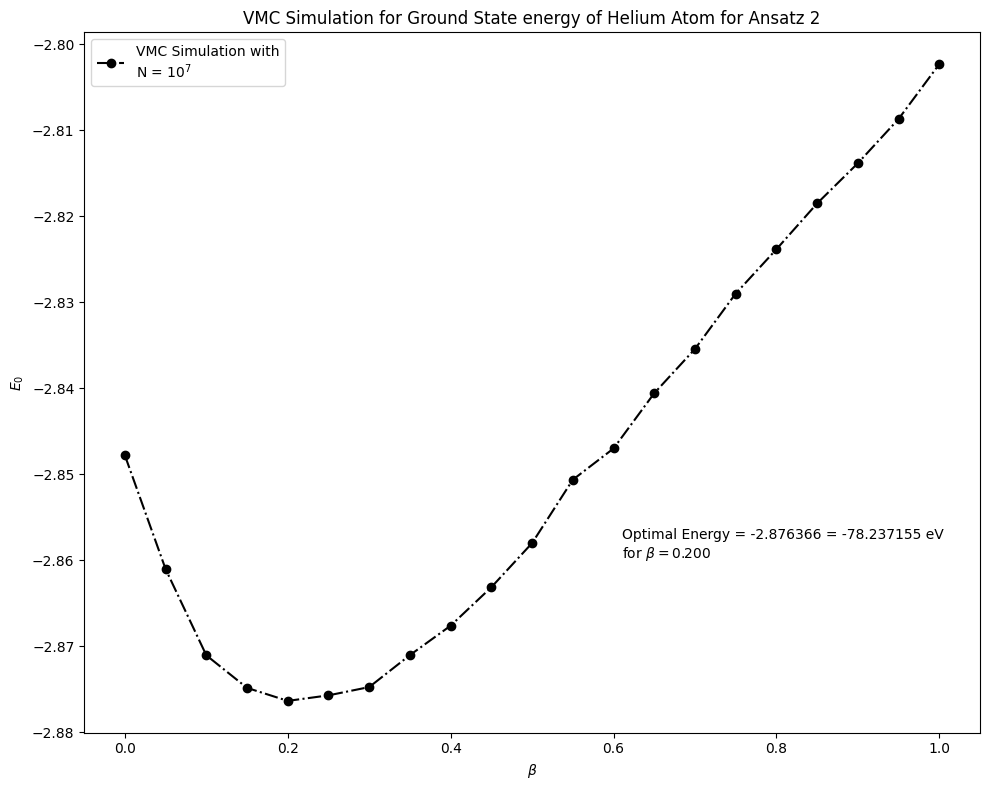

In [43]:
plt.figure(figsize=(10,8))
plt.plot(beta_list_2, E_list_2,'ko-.', label='VMC Simulation with\nN = $10^7$')
plt.title('VMC Simulation for Ground State energy of Helium Atom for Ansatz 2')
plt.xlabel('$\\beta$')
plt.ylabel('$E_0$')
plt.legend()
plt.tight_layout()
plt.text(0.6,0.25,
         "Optimal Energy = %f = %f eV \nfor $\\beta = %0.3f$"%(min(E_list_2),min(E_list_2)*2*13.6, opt_beta_2),
         transform=plt.gca().transAxes)
plt.show()

### $\text{Data for Ansatz 2 in 2D}$

In [44]:
def ansatz2_2d():
    a = opt_alpha_1
    b = opt_beta_2
    alpha_list = np.linspace(a - 0.3, a + 0.3, 7)
    beta_list = np.linspace(b - 0.1, b + 0.5, 7)
    
    N_thermal = 10**3
    step = 1.0

    Z = 2

    np.random.random(1729)
    r = step * (np.random.random((2,3)) - 0.5)

    N = 10**7
    results_coarse = []
    for i in tqdm(range(len(alpha_list))):
        for j in range(len(beta_list)):
            res = VMC_2(r.copy(), alpha_list[i], beta_list[j], Z, N_thermal, N, step)
            results_coarse.append((alpha_list[i], beta_list[j], res[0], res[1]))
    combined_df = pd.DataFrame(results_coarse, columns=['alpha', 'beta', 'energy', 'variance'])

    return alpha_list, beta_list, combined_df

alpha_list_2_1, beta_list_2_1, combined_df_2_1 = ansatz2_2d()

100%|██████████| 7/7 [01:46<00:00, 15.24s/it]


In [45]:
energy_grid_2_1 = np.array(combined_df_2_1['energy']).reshape(len(alpha_list_2_1), len(beta_list_2_1))

min_flat_index = np.argmin(energy_grid_2_1)

# Convert to row, column indices
row_idx, col_idx = np.unravel_index(min_flat_index, energy_grid_2_1.shape)

opt_alpha_2_1 = alpha_list_2_1[row_idx]
opt_beta_2_1 = beta_list_2_1[col_idx]

### $\text{Plot for Ansatz 2 for 2d}$

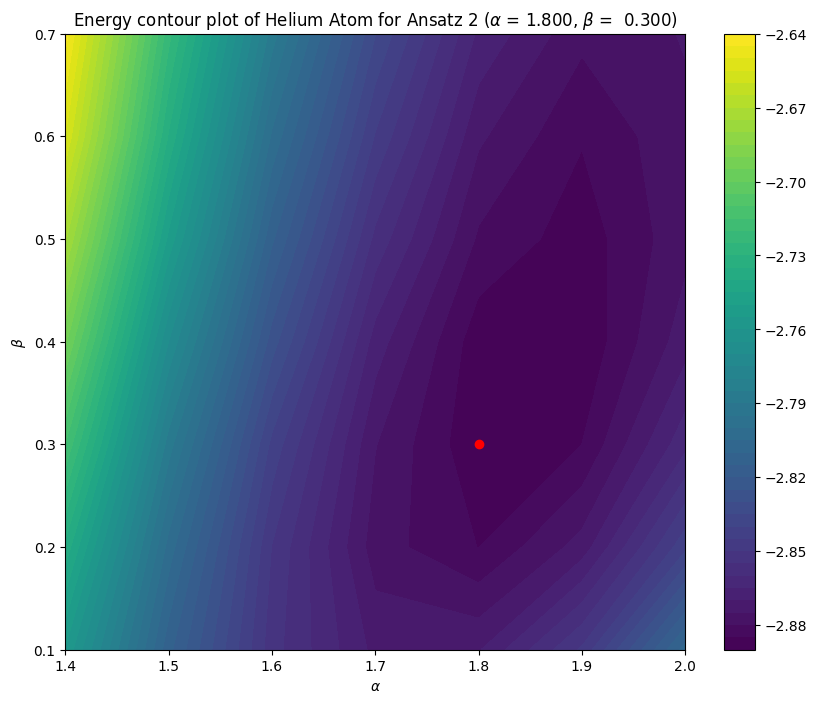

In [47]:
Y, X = np.meshgrid(beta_list_2_1, alpha_list_2_1)

plt.figure(figsize=(10,8))
plt.title(f"Energy contour plot of Helium Atom for Ansatz 2 ($\\alpha$ ={opt_alpha_2_1: 0.3f}, $\\beta$ = {opt_beta_2_1: 0.3f})")
plt.ylabel("$\\beta$")
plt.xlabel("$\\alpha$")
plt.plot(opt_alpha_2_1,opt_beta_2_1, 'ro')
contour = plt.contourf(X, Y, energy_grid_2_1, 50, cmap='viridis')
plt.colorbar(contour)
plt.show()

### $\text{Mean } r_{12} \text{ for Ansatz 2}$

In [48]:
@njit(cache = True)
def r12_monte_carlo_2(r, a, b, Z, N_thermal, N, step):
    r12_sum = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_2(r, a, b)
        wave_new = psi_2(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_2(r, a, b)
        wave_new = psi_2(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        r_12 = 0.0
        for k in range(3):
            r_12 += (r[0,k]-r[1,k])**2
        r12 = math.sqrt(r_12)
        
        r12_sum += r12
        
    return r12_sum / N

In [49]:
N_thermal = 10**3
N = 10**7
a = opt_alpha_2_1
b = opt_beta_2_1
step = 1.0
Z = 2


r = step * (np.random.random((2,3)) - 0.5)

r12opt_2 = r12_monte_carlo_2(r, a, b, Z, N_thermal, N, step)
print(r12opt_2)

1.3868509614817615


In [50]:
print("Comments:")
print(f"- Optimal value of alpha for Ansatz 2 = {opt_alpha_2_1: 0.3f}")
print(f"- Optimal value of beta  for Ansatz 2 = {opt_beta_2_1: 0.3f}")
print(f"- Mean r_12 for Ansatz 2 = {r12opt_2: 0.3f}")

Comments:
- Optimal value of alpha for Ansatz 2 =  1.800
- Optimal value of beta  for Ansatz 2 =  0.300
- Mean r_12 for Ansatz 2 =  1.387


## $\text{Ansatz 3}$

### $\text{Defining Functions}$

In [51]:
# Wavefunction 3

@njit(cache=True)
def psi_3(r, a, b):
    m,n = r.shape
    arg = 0.0
    for i in range(m):
        r_particle = 0.0
        for j in range(n):
            r_particle += r[i,j]**2
        arg += math.sqrt(r_particle)

    r_12 = 0.0
    for k in range(n):
        r_12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r_12)
    return math.exp(-a*arg) * math.exp(0.5 * r12/(1 + b*r12))

In [52]:
# Local energy for Wavefunction 3

@njit(cache=True)
def local_energy_3(r, a, b, Z):
    eps = 1e-9
    r1_sq = 0.0
    for i in range(3):
        r1_sq += r[0,i]**2
    r1 = math.sqrt(r1_sq) + eps
       
    r2_sq = 0.0
    for i in range(3):
        r2_sq += r[1,i]**2
    r2 = math.sqrt(r2_sq) + eps
       
    r12_sq = 0.0
    for k in range(3):
        r12_sq += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12_sq) + eps
        
    T_dot = (r1_sq - r2_sq + r12_sq)/(2 * r1 * r12) + (r2_sq - r1_sq + r12_sq)/(2 * r2 * r12)
    
    E = (a - Z)*(1/r1 + 1/r2) + 1/r12 - a**2 + 0.5/(1 + b*r12)**2 * (a* T_dot - 0.5/(1 + b*r12)**2 - 2/r12 + 2*b/(1 + b*r12)) 
    return E

In [53]:
# Monte Carlo for Wavefunction 3

@njit(cache=True)
def monte_carlo_3(r, a, b, Z, N_thermal, N, step):
    energy = 0.0
    energy2 = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_3(r, a, b)
        wave_new = psi_3(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_3(r, a, b)
        wave_new = psi_3(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        dE = local_energy_3(r, a, b, Z)
        energy += dE
        energy2 += dE**2
        
    return energy, energy2

@njit(cache=True)
def VMC_3(r, a, b, Z, N_thermal, N, step):
    energy, energy2 = monte_carlo_3(r.copy(), a, b, Z, N_thermal, N, step)
    
    energy_mean = energy / N
    energy_var = energy2 / N - energy_mean**2
    
    return energy_mean, energy_var

### $\text{Data for Ansatz 3}$

In [54]:
def ansatz3():
    N_thermal = 10**3
    step = 1.0

    Z = 2

    r = step * (np.random.random((2,3)) - 0.5)

    beta_list = np.linspace(0, 2, 21)
    a = opt_alpha_1
    N = 10**7
    results_coarse = []
    for i in tqdm(range(len(beta_list))):
        res = VMC_3(r.copy(), a, beta_list[i], Z, N_thermal, N, step)
        results_coarse.append((beta_list[i], res[0], res[1]))
    combined_df = pd.DataFrame(results_coarse, columns=['beta', 'energy', 'variance'])

    return combined_df

combined_df_3 = ansatz3()

100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


In [55]:
E_list_3 = combined_df_3['energy']
beta_list_3 = combined_df_3['beta']
opt_beta_3 = beta_list_3[np.argmin(E_list_3)]
combined_df_3

,beta,energy,variance
0,0.0,-2.738400,0.614538
1,0.1,-2.824000,0.456413
2,0.2,-2.854518,0.411493
3,0.3,-2.868190,0.361848
4,0.4,-2.875455,0.359429
5,0.5,-2.877166,0.333498
6,0.6,-2.878706,0.348292
7,0.7,-2.879396,0.341240
8,0.8,-2.878909,0.353688
9,0.9,-2.877601,0.360246


### $\text{Plot for Ansatz 3}$

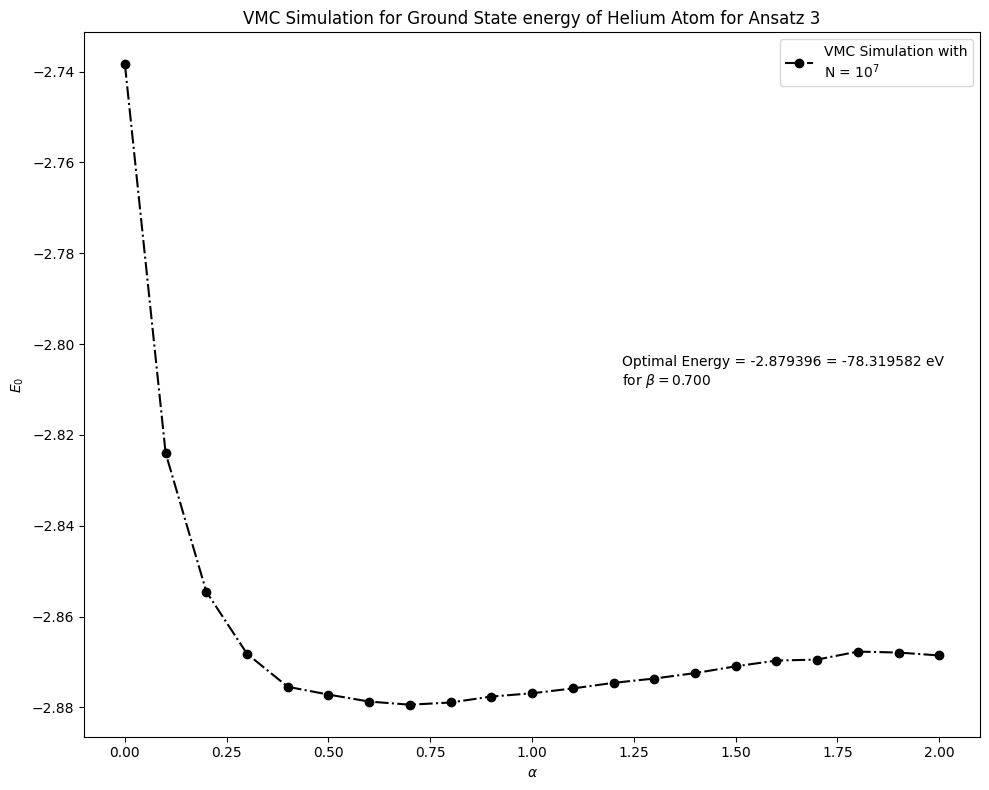

In [56]:
plt.figure(figsize=(10,8))
plt.plot(beta_list_3, E_list_3,'ko-.', label='VMC Simulation with\nN = $10^7$')
plt.title('VMC Simulation for Ground State energy of Helium Atom for Ansatz 3')
plt.xlabel('$\\alpha$')
plt.ylabel('$E_0$')
plt.legend()
plt.tight_layout()
plt.text(0.6,0.5,
         "Optimal Energy = %f = %f eV \nfor $\\beta = %0.3f$"%(min(E_list_3),min(E_list_3)*2*13.6, opt_beta_3),
         transform=plt.gca().transAxes)
plt.show()

### $\text{Data for Ansatz 3 in 2D}$

In [57]:
def ansatz3_2d():
    a = opt_alpha_1
    b = opt_beta_3
    alpha_list = np.linspace(a - 0.2, a + 0.4, 7)
    beta_list = np.linspace(b - 0.5, b + 0.1, 7)
    
    N_thermal = 10**3
    step = 1.0

    Z = 2


    r = step * (np.random.random((2,3)) - 0.5)

    N = 10**7
    results_coarse = []
    for i in tqdm(range(len(alpha_list))):
        for j in range(len(beta_list)):
            res = VMC_3(r.copy(), alpha_list[i], beta_list[j], Z, N_thermal, N, step)
            results_coarse.append((alpha_list[i], beta_list[j], res[0], res[1]))
    combined_df = pd.DataFrame(results_coarse, columns=['alpha', 'beta', 'energy', 'variance'])

    return alpha_list, beta_list, combined_df

alpha_list_3_1, beta_list_3_1, combined_df_3_1 = ansatz3_2d()

100%|██████████| 7/7 [01:54<00:00, 16.33s/it]


In [58]:
energy_grid_3_1 = np.array(combined_df_3_1['energy']).reshape(len(alpha_list_3_1), len(beta_list_3_1))

min_flat_index = np.argmin(energy_grid_3_1)

# Convert to row, column indices
row_idx, col_idx = np.unravel_index(min_flat_index, energy_grid_3_1.shape)

opt_alpha_3_1 = alpha_list_3_1[row_idx]
opt_beta_3_1 = beta_list_3_1[col_idx]

### $\text{Plot for Ansatz 3 in 2D}$

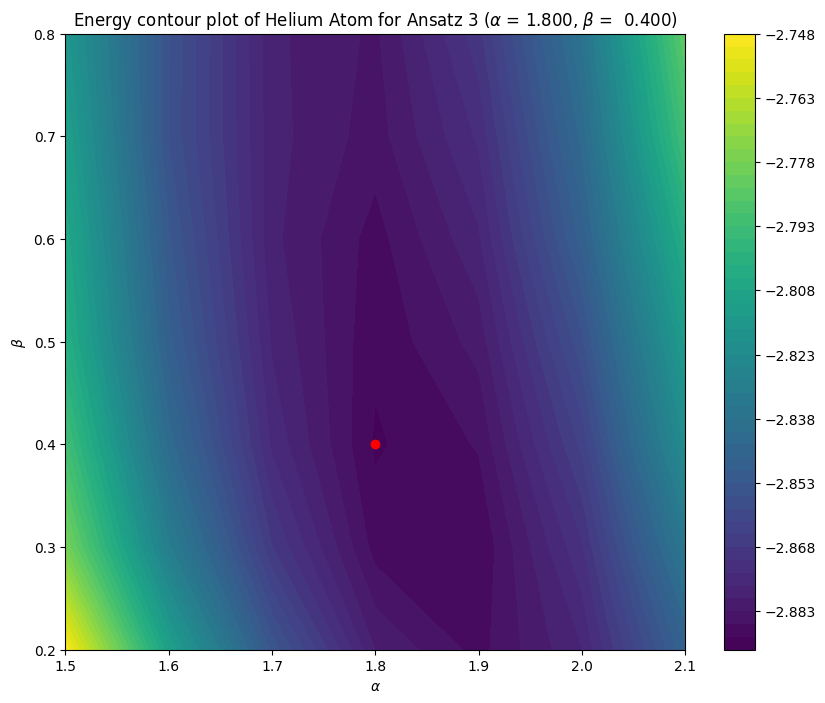

In [60]:
Y, X = np.meshgrid(beta_list_3_1, alpha_list_3_1)

plt.figure(figsize=(10,8))
plt.title(f"Energy contour plot of Helium Atom for Ansatz 3 ($\\alpha$ ={opt_alpha_3_1: 0.3f}, $\\beta$ = {opt_beta_3_1: 0.3f})")
plt.ylabel("$\\beta$")
plt.xlabel("$\\alpha$")
plt.plot(opt_alpha_3_1, opt_beta_3_1, 'ro')
contour = plt.contourf(X, Y, energy_grid_3_1, 50, cmap='viridis')
plt.colorbar(contour)
plt.show()

### $\text{Mean } r_{12} \text{ for Ansatz 3}$

In [61]:
@njit(cache=True)
def r12_monte_carlo_3(r, a, b, Z, N_thermal, N, step):
    r12_sum = 0.0
    m,n = r.shape
    
    for _ in range(N_thermal):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_3(r, a, b)
        wave_new = psi_3(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new
    
    for _ in range(N):
        r_new = r + step * (np.random.random(r.shape) - 0.5)
        wave = psi_3(r, a, b)
        wave_new = psi_3(r_new, a, b)
        
        if np.random.random() < (wave_new/wave)**2:
            r = r_new  
        
        r_12 = 0.0
        for k in range(3):
            r_12 += (r[0,k]-r[1,k])**2
        r12 = math.sqrt(r_12)
        
        r12_sum += r12
        
    return r12_sum / N

In [62]:
N_thermal = 10**3
N = 10**7
a = opt_alpha_3_1
b = opt_beta_3_1
step = 1.0
Z = 2


r = step * (np.random.random((2,3)) - 0.5)

r12opt_3 = r12_monte_carlo_3(r, a, b, Z, N_thermal, N, step)
print(r12opt_3)

1.3801064202986704


In [63]:
print("Comments:")
print(f"- Optimal value of alpha for Ansatz 3 = {opt_alpha_3_1: 0.3f}")
print(f"- Optimal value of beta  for Ansatz 3 = {opt_beta_3_1: 0.3f}")
print(f"- Mean r_12 for Ansatz 3 = {r12opt_3: 0.3f}")

Comments:
- Optimal value of alpha for Ansatz 3 =  1.800
- Optimal value of beta  for Ansatz 3 =  0.400
- Mean r_12 for Ansatz 3 =  1.380
